# Fraud detection

## Introduction

We have a fraud detection problem, which is an unsupervised machine learning problem, known as anomaly detection. And the main idea of solving this problem is to find observations, that are not typical for this data. Maybe they comes from another distribution, maybe they are result of an error, but we always have to pay attention to such points. Because like in this case it could do harm to your business. Here we won't touch economic aspect of fraud detection,  either fraud non detection or false fraud detection aren't good. Below all principle steps of data analysis and model training are described.   

We install necessary libraries. We use here:
* <b>Pandas</b> to work with dataframes, 
* <b>Numpy</b> to work with numpy arrays and numerical calculations, 
* <b>Matplotlib</b> and <b>Seaborn</b> to visualize data, 
* <b>Scikit Learn</b> for data preprocessing and machine learning algorithms  

In [196]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn
import sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
% matplotlib inline

Checking libraries' versions

In [139]:
print('Pandas:', pd.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Seaborn:', seaborn.__version__)
print('Scikit Learn:', sklearn.__version__)

Pandas: 0.20.3
Numpy: 1.13.1
Matplotlib: 2.0.2
Seaborn: 0.8.0
Scikit Learn: 0.19.0


We import data and take a quick look on first five observations. We have $34$ features and $7673$ obervations, and some features have a lot of missing values

In [122]:
pd.set_option('max_columns', 35)
df = pd.read_csv('TEST_DATA.csv', index_col = 0, na_values = 'n/a')
print('Number of observations: {:d} \nNumber of features: {:d}'.format(df.shape[0], df.shape[1]))
df.head()

Number of observations: 7673 
Number of features: 34


,3D Authenticated,3D Offered,Browser,CVM Performed,CVM Result,Creation Date,Currency,DCC Accepted,Delivery Date,Device type,Entry Mode,Event,Issuer Country,Liability Indicator,Payment Method,Shopper Country,Shopper IP,Shopper Interaction,TimeZone,User Name,Value,ver_email,ver_phone,Avg_order_time,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,varience,skew,LABEL Status,LABEL Fraud Scoring
0,Y,Y,Safari,NaN,NaN,2016-12-01 16:54:37,EUR,NaN,NaN,Other,NaN,NaN,FR,Y,cartebancaire,FR,88.168.245.32,Ecommerce,CET,ws@Company.BackMarket,283.59,1.0,1.0,0.00000,0.0,5382.179047,0.000000,0.0,259.000000,0.000000,0.000000,0.00000,Authorised,25
1,A,Y,Chrome,NaN,NaN,2016-12-01 16:54:11,EUR,NaN,NaN,Other,NaN,NaN,BE,Y,mc,BE,91.176.162.85,Ecommerce,CET,ws@Company.BackMarket,197.99,1.0,1.0,914.42197,46.0,4176.131101,1.869565,0.0,168.033478,20.480061,438.498024,-0.63901,Cancelled,189
2,Y,Y,FireFox,NaN,NaN,2016-12-01 16:52:51,EUR,NaN,NaN,Other,NaN,NaN,CH,Y,visa,CH,145.232.108.212,Ecommerce,CET,ws@Company.BackMarket,183.90,1.0,1.0,0.00000,0.0,0.000000,0.000000,0.0,177.000000,0.000000,0.000000,0.00000,Authorised,25
3,Y,Y,Safari,NaN,NaN,2016-12-01 16:52:46,EUR,NaN,NaN,iPad,NaN,NaN,FR,Y,cartebancaire,FR,176.132.222.71,Ecommerce,CET,ws@Company.BackMarket,312.00,1.0,1.0,0.00000,0.0,0.000000,0.000000,0.0,307.000000,0.000000,0.000000,0.00000,Authorised,25
4,Y,Y,IE11,NaN,NaN,2016-12-01 16:52:21,EUR,NaN,NaN,Other,NaN,NaN,FR,Y,cartebancaire,FR,79.92.249.94,Ecommerce,CET,ws@Company.BackMarket,135.90,1.0,1.0,0.00000,0.0,0.000000,0.000000,0.0,129.000000,0.000000,0.000000,0.00000,Authorised,25


Now let's take a look on fraud's features: <u>'LABEL Status'</u> and <u>'LABEL Fraud Scoring'</u>. We see that the number of refused attempts is enormously large in this dataset, more than $25\%$ were refused. This proportion is really huge, according to different sources, the number of fraudulent attempts varies from <a href="http://www.businesswire.com/news/home/20151118005120/en/Online-Retail-Fraud-Attempts-Increased-30-YearTaking">$1$ out of $86$ transactions in $2015$ for US and Canada</a> till <a href="https://www.cybersource.com/content/dam/cybersource/2017_Fraud_Benchmark_Report.pdf">$2.5 - 3\%$ in $2017$ in the same countries</a>. There is no reason to think that there are ten times more fraudulent attempts in Europe, than in North America. So either the data is not random (sample was chosen so that there were many negative obervations) or fraudulent transactions are oversampled, it means the same observations were added to the data frame, maybe with little changes, to increase the number of negative observations. And from theoretical point of view it is important to mention, that fraud detection is not a classification problem, but unsupervised learning problem of anomaly detection, and the number of anomalies is very small, $1-3\%$, but usually even less.  

As for fraud scoring, we see that higher fraud scores correspond to fraudulent attemts. We also see that some observations several variables are equal, so there might be several attempts.

In [123]:
print(df['LABEL Status'].value_counts())
df.sort_values('LABEL Fraud Scoring', ascending = False).head(20)

Authorised       2714
Refused          2050
Settled          1613
SentForSettle     718
SettledBulk       253
Refunded          189
Cancelled          99
Expired            20
SentForRefund      11
RefundedBulk        6
Name: LABEL Status, dtype: int64


,3D Authenticated,3D Offered,Browser,CVM Performed,CVM Result,Creation Date,Currency,DCC Accepted,Delivery Date,Device type,Entry Mode,Event,Issuer Country,Liability Indicator,Payment Method,Shopper Country,Shopper IP,Shopper Interaction,TimeZone,User Name,Value,ver_email,ver_phone,Avg_order_time,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,varience,skew,LABEL Status,LABEL Fraud Scoring
209,NaN,NaN,FireFox,NaN,NaN,2016-12-01 13:08:21,EUR,NaN,NaN,Other,NaN,NaN,GB,N,visa,GB,51.6.155.162,Ecommerce,CET,ws@Company.BackMarket,1398.00,1.0,1.0,2551.839103,17.121951,0.000000,-4.511852,-13.269231,626.645926,227.481525,53738.145802,0.302627,Refused,774
204,NaN,NaN,FireFox,NaN,NaN,2016-12-01 13:10:54,EUR,NaN,NaN,Other,NaN,NaN,GB,N,visa,GB,51.6.155.162,Ecommerce,CET,ws@Company.BackMarket,699.00,1.0,1.0,2551.839103,17.121951,0.000000,-4.511852,-13.269231,626.645926,227.481525,53738.145802,0.302627,Refused,741
2145,NaN,NaN,NaN,NaN,NaN,2016-12-03 21:32:25,EUR,NaN,NaN,NaN,NaN,NaN,GB,NaN,mc,GB,45.76.128.41,NaN,CET,NaN,649.00,1.0,1.0,2551.839103,17.121951,0.000000,-4.511852,-13.269231,626.645926,227.481525,53738.145802,0.302627,Refused,643
4239,NaN,NaN,NaN,NaN,NaN,2016-12-05 20:23:04,EUR,NaN,NaN,NaN,NaN,NaN,GB,NaN,visa,GB,45.76.128.41,NaN,CET,NaN,649.00,1.0,1.0,2551.839103,17.121951,0.000000,-4.511852,-13.269231,626.645926,227.481525,53738.145802,0.302627,Refused,545
9451,NaN,NaN,NaN,NaN,NaN,2016-11-29 10:25:26,EUR,NaN,NaN,NaN,NaN,NaN,FR,NaN,cartebancaire,DE,62.225.150.101,NaN,CET,NaN,211.00,1.0,1.0,277.058824,306.000000,0.000000,0.611111,-0.117647,224.888889,19.609773,407.163399,0.194021,Refused,543
9497,NaN,NaN,NaN,NaN,NaN,2016-11-29 09:20:56,EUR,NaN,NaN,NaN,NaN,NaN,FR,NaN,cartebancaire,DE,62.225.150.101,NaN,CET,NaN,211.00,1.0,1.0,277.058824,306.000000,0.000000,0.611111,-0.117647,224.888889,19.609773,407.163399,0.194021,Refused,541
9382,NaN,NaN,NaN,NaN,NaN,2016-11-29 12:02:30,EUR,NaN,NaN,NaN,NaN,NaN,FR,NaN,cartebancaire,DE,62.225.150.101,NaN,CET,NaN,211.00,1.0,1.0,277.058824,306.000000,0.000000,0.611111,-0.117647,224.888889,19.609773,407.163399,0.194021,Refused,537
9450,NaN,NaN,NaN,NaN,NaN,2016-11-29 10:26:16,EUR,NaN,NaN,NaN,NaN,NaN,FR,NaN,cartebancaire,DE,62.225.150.101,NaN,CET,NaN,211.00,1.0,1.0,277.058824,306.000000,0.000000,0.611111,-0.117647,224.888889,19.609773,407.163399,0.194021,Refused,535
4237,NaN,NaN,NaN,NaN,NaN,2016-12-05 20:25:39,EUR,NaN,NaN,NaN,NaN,NaN,GB,NaN,visa,GB,45.76.128.41,NaN,CET,NaN,305.90,1.0,1.0,2551.839103,17.121951,0.000000,-4.511852,-13.269231,626.645926,227.481525,53738.145802,0.302627,Refused,522
8833,NaN,NaN,NaN,NaN,NaN,2016-11-29 21:05:32,EUR,NaN,NaN,NaN,NaN,NaN,FR,NaN,cartebancaire,FR,77.150.104.169,NaN,CET,NaN,214.00,1.0,1.0,277.058824,306.000000,0.000000,0.611111,-0.117647,224.888889,19.609773,407.163399,0.194021,Refused,489


And as we are not very interested of all statuts, we create variable <u>'Refused'</u>, equal to $1$ if status is refused, and $0$ if not

In [124]:
df['Refused'] = [1 if x == 'Refused' else 0 for x in df['LABEL Status'].values]

## Exploratory data analysis

### Getting more familiar with features

For convenience, at first we will work separately with categorical and numerical features. Let's look at summary of numerical features. We have $19$ numerical features and we see that features <u>'CVM Performed'</u>, <u>'CVM Result'</u>, <u>'DCC Accepted'</u>, <u>'Delivery Date'</u>, <u>'Entry Mode'</u>, <u>'Event'</u> have only missing values. Moreover we see, that feature <u>'ver_email'</u> is a constant feature, which is always equal to one (or is missing), and feature <u>'ver_phone'</u> is actually binary feature, and not numerical one. Later we will drop these features, because they don't add any information, and change type for <u>'ver_phone'</u>. For features <u>'Avg_IP_distance'</u>, <u>'avg_grad'</u>, <u>'avg_diff_grad'</u>, <u>'std_dev'</u>, <u>'varience'</u>, <u>'skew'</u> there are many zero values, we could think that these features might be preprocessed, and missing values were replaced by zeros. But they already have NaN's. Feature <u>'Avg_order_freq'</u> has infinite values, but also has NaN's. Nevertheless, we have to replace inf values, to be able to work with this feature. We will replace it by zero, so  we won't take into account these values. And the last remark, that for all features except <u>'Value'</u> and <u>'LABEL Fraud Scoring'</u> the number of non missing values is the same. 

In [125]:
df_num = df.select_dtypes(exclude = ['object']).drop('Refused', axis = 1)
df_cat = df.select_dtypes(include = ['object']).drop('LABEL Status', axis = 1)
print('Number of numerical features: {:d}'.format(df_num.shape[1]))
df_num.describe()

Number of numerical features: 19


,CVM Performed,CVM Result,DCC Accepted,Delivery Date,Entry Mode,Event,Value,ver_email,ver_phone,Avg_order_time,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,varience,skew,LABEL Fraud Scoring
count,0.0,0.0,0.0,0.0,0.0,0.0,7673.000000,7390.0,7390.000000,7.390000e+03,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000,7.390000e+03,7390.000000,7673.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,372.674346,1.0,0.993505,1.476676e+04,inf,1748.716148,-0.937261,-0.813153,325.679474,26.103044,1.063213e+04,0.012676,36.904470
std,NaN,NaN,NaN,NaN,NaN,NaN,2426.298503,0.0,0.080336,5.882005e+04,NaN,2457.987603,55.910904,32.816874,202.647834,91.891793,1.303413e+05,0.675989,50.753829
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,0.000000,0.000000e+00,0.000000,0.000000,-938.000000,-625.505000,9.000000,0.000000,0.000000e+00,-4.321795,-190.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,199.000000,1.0,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,199.000000,0.000000,0.000000e+00,0.000000,20.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,308.000000,1.0,1.000000,3.394444e+00,0.195994,0.000000,0.000000,0.000000,300.630000,0.000000,0.000000e+00,0.000000,25.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,408.900000,1.0,1.000000,8.263479e+02,inf,4967.630295,0.000000,0.000000,399.000000,9.046038,1.200000e+02,0.000000,35.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,150000.000000,1.0,1.000000,1.048504e+06,inf,9256.840424,1034.000000,458.252500,2976.000000,1970.173062,4.036845e+06,4.707155,774.000000


Now let's take a look on categorical features. Their total number is $15$, and we see, that we have 3 constant features <u>'Currency'</u>, <u>'Shopper Interaction'</u>, <u>'TimeZone'</u>. Also for features <u>'Browser'</u>, <u>'Device type'</u>, <u>'Liability Indicator'</u>, <u>'User Name'</u> about $87\% - 88\%$ of values are missing. Feature <u>'Creation Date'</u> actually is not categorical one, but obviously a date. So we won't use it as categorical feature, but we will use it as date. Later we will drop constant features (except of <u>'Shopper Interaction'</u>, treating missing value as another category might be useful) and will decide what to do with missing values

In [126]:
print('Number of categorical features: {:d}'.format(df_cat.shape[1]))
df_cat.describe()

Number of categorical features: 14


,3D Authenticated,3D Offered,Browser,Creation Date,Currency,Device type,Issuer Country,Liability Indicator,Payment Method,Shopper Country,Shopper IP,Shopper Interaction,TimeZone,User Name
count,6720,6801,972,7673,7673,972,7673,960,7673,7673,7509,1000,7673,1000
unique,4,3,8,7550,1,5,37,2,13,37,5234,1,1,2
top,Y,Y,Chrome,2016-11-29 20:10:05,EUR,Other,FR,Y,cartebancaire,FR,10.246.12.115,Ecommerce,CET,ws@Company.BackMarket
freq,5922,6720,458,5,7673,791,6717,722,6415,5886,366,1000,7673,972


After dropping of constant or missing features, we have $11$ numerical and $12$ categorical features. 

In [127]:
df_cat.drop(['Currency', 'TimeZone', 'Creation Date'], axis = 1, inplace = True)
df_cat['ver_phone'] = ['Yes' if x == 1 else 'No' for x in df_num['ver_phone'].values]
df_num.drop(['CVM Performed', 'CVM Result', 'DCC Accepted', 'Delivery Date', 
             'Entry Mode', 'Event', 'ver_email', 'ver_phone'], axis = 1, inplace = True)
df_num['Avg_order_freq'].replace(np.inf, 0, inplace = True)

print('Number of numerical features: {:d} \nNumber of categorical features: {:d}'.format(df_num.shape[1], df_cat.shape[1]))

Number of numerical features: 11 
Number of categorical features: 12


Finally let's have a look on <u>'Creation Date'</u> feature. We see that all the purchases had been made between the third november and the eighth december $2016$. 

In [128]:
df['Creation Date'] = pd.to_datetime(df['Creation Date'])
df['Creation Date'].describe()

count                    7673
unique                   7550
top       2016-12-01 16:10:07
freq                        5
first     2016-11-03 15:14:37
last      2016-12-08 14:01:52
Name: Creation Date, dtype: object

### Dealing with categorical features

As we have seen above, we have $12$ categorical features, but for feature <u>'Shopper IP'</u> we have more than $5000$ unique values. So using One Hot Encoder won't work here, we will work with this feature in feature engineering section. For other categorical features we don't have s huge number of categories, we visualize them, using countplots and 'Refused' feature see the number of negative observations in every category. We also replace all missing values by NaN category, to see this number also for them.

Now we'll make countplots for categorical features. For features <u>'3D Authenticated'</u> and <u>'3D Offered'</u> we see, that if category is N or NaN, almost every time we have fraudulent attempt. It's the same category N for feature <u>'Liability Indicator'</u>. We see that for almost every feature we have very rare categories. Perhaps we could reduce the number of categories in some features by creating a new category 'Others' for all rare categories. 

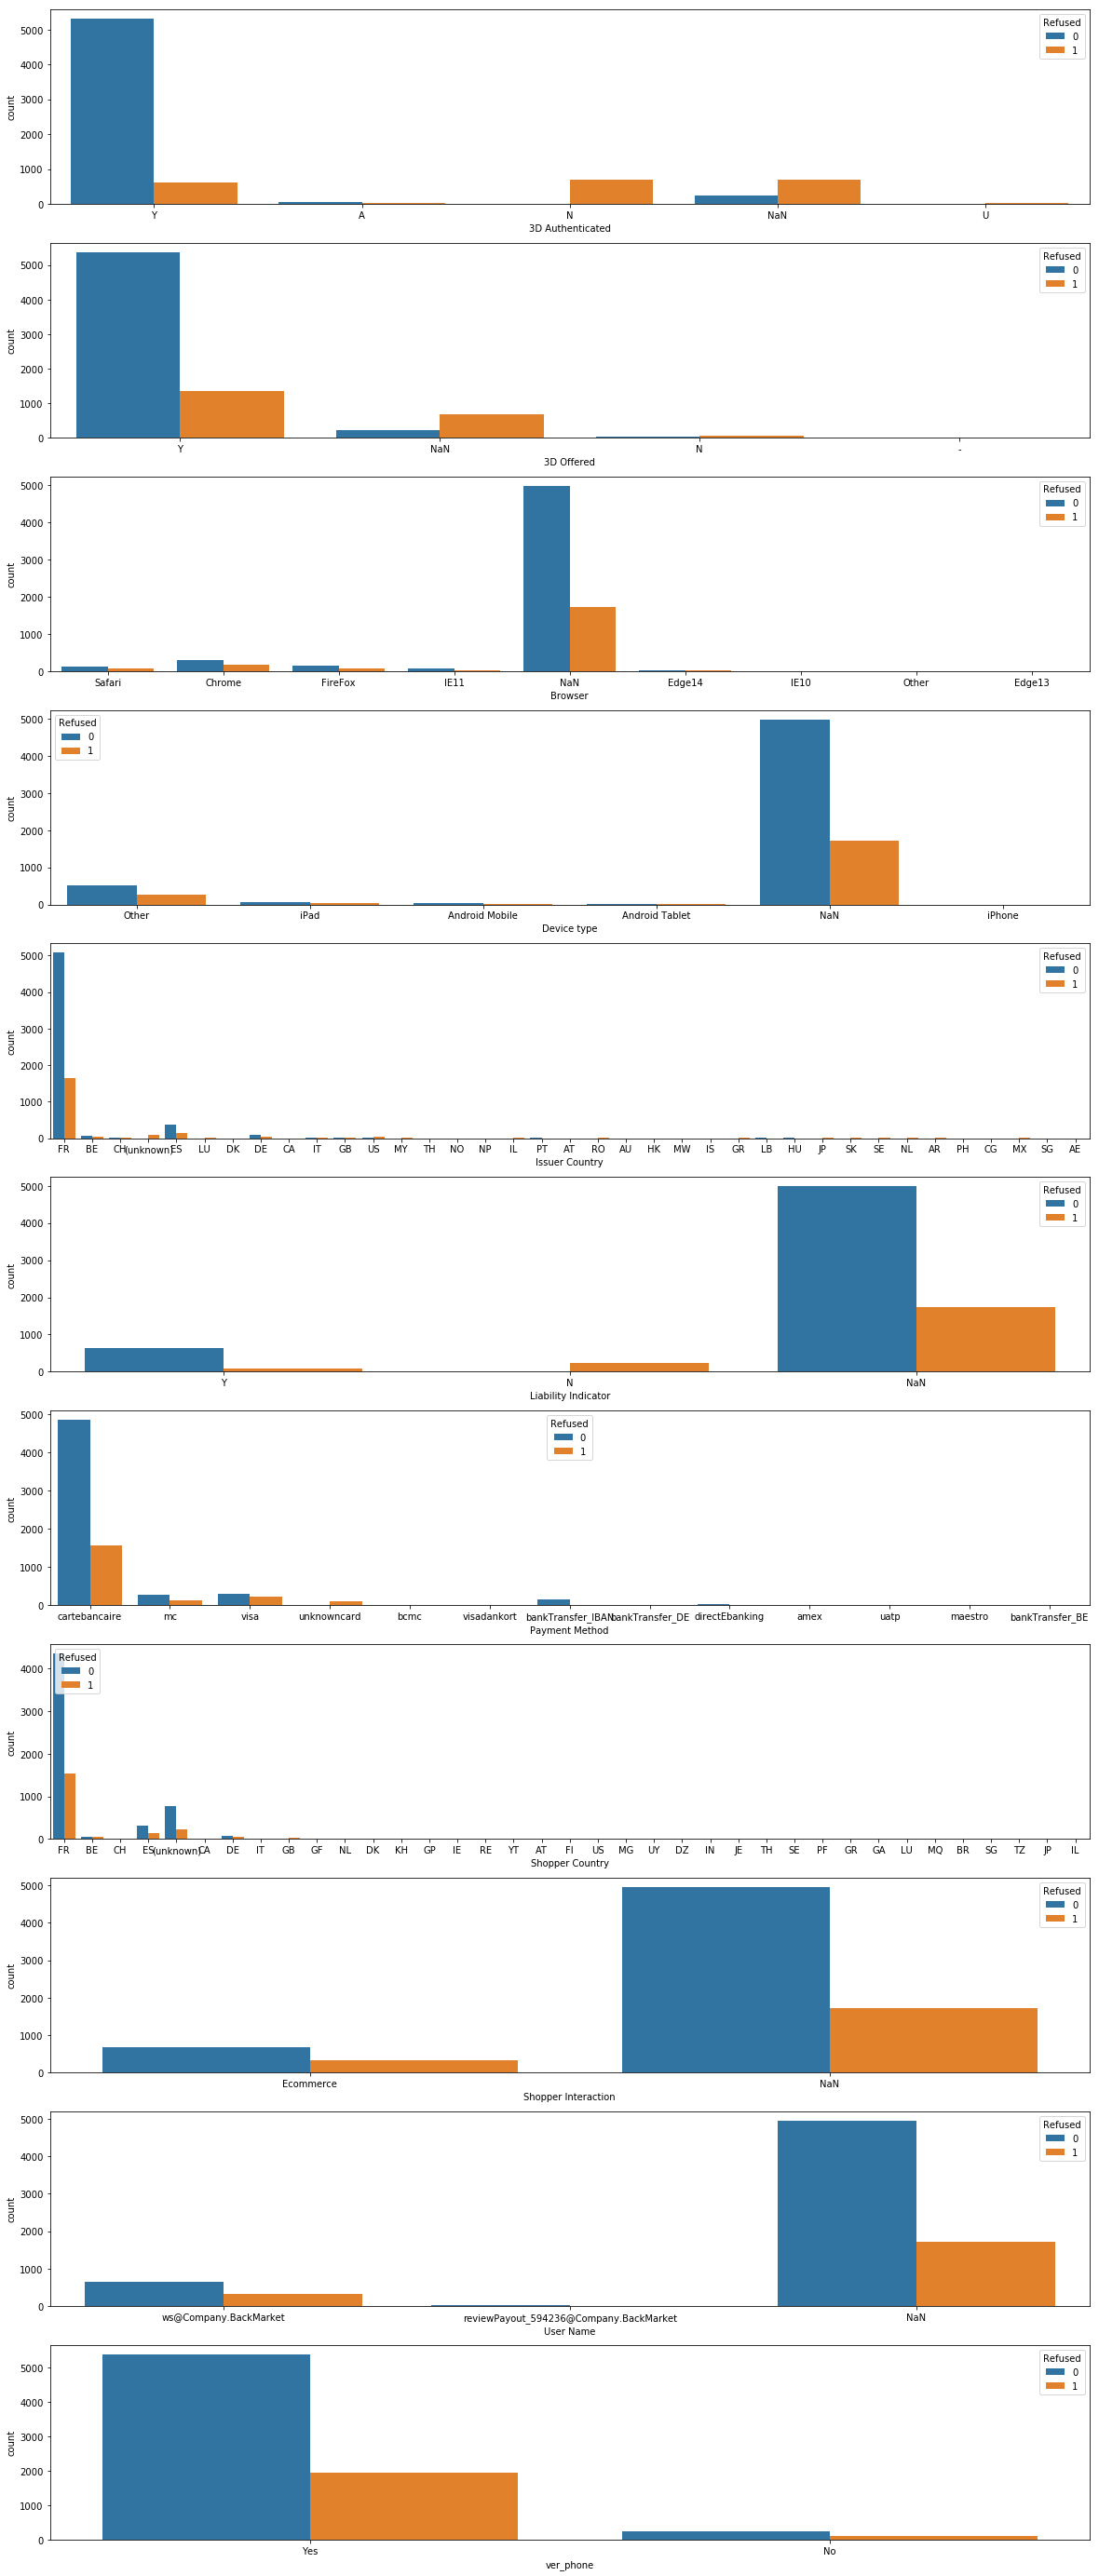

In [129]:
cat_features = df_cat.drop('Shopper IP', axis = 1).columns
df_cat.fillna('NaN', inplace = True)
plt.figure(figsize = (20, 50))
for i, feature in enumerate(cat_features):
    plt.subplot(len(cat_features), 1, i + 1)
    seaborn.countplot(x = feature, data = df_cat, hue = df['Refused'])

### Dealing with numerical features

To explore better numerical features, we will calculate correlation among every numerical feature and <u>'Refused'</u> feature, pair correlation (with heatmap) and we will make pairplot. We won't make boxplots here, because we have many sparse numerical features.

We'll begin with correlation between numerical features and <u>'Refused'</u>. The problem is that <u>'Refused'</u> is binary feature. Of course, we can calculate here pearson's or spearman's correlation, but in this case for feature $i$ it would be better to calculate the difference of expected values when <u>'Refused'</u> is equal to $1$ and $0$:

$$ cor(X^i, Y) = \mathbb E(X^i_{scaled} | Y = 1) - \mathbb E(X^i_{scaled} | Y = 0)$$

We use scaling here, because without it we could decide only if features are positively or negatively correlated, but not strongly or weakly. We see that <u>'Avg_order_time'</u> is negatively correlated with <u>'Refused'</u> and <u>'varience'</u>, <u>'std_dev'</u>, <u>'Avg_order_freq'</u> and <u>'mean'</u> are positively correlated, and for mean correlation is more than $0.5$. The highest correlation has <u>'LABEL Fraud Scoring'</u>, but it's quite obvious, because this is the result of the original model, and this feature won't be used for fraud detection.

In [151]:
def feature_scale(x):
    return((x - x.mean(skipna = True)) / x.std(skipna = True))

df_num_scaled = df_num.copy()
for feature in df_num_scaled.columns:
    df_num_scaled[feature] = feature_scale(df_num_scaled[feature])
df_num_scaled.head()
correlations = pd.DataFrame((df_num_scaled[df['Refused'] == 1].mean(axis = 0, skipna = True) - 
                             df_num_scaled[df['Refused'] == 0].mean(axis = 0, skipna = True)),
                             columns = ['correlation']).dropna().sort_values(by = 'correlation')
correlations

,correlation
Avg_order_time,-0.226725
avg_diff_grad,-0.051223
Avg_IP_distance,-0.050935
IP frequency,-0.038923
avg_grad,-0.018787
skew,-0.010970
Value,0.034395
IP time diff,0.076179
varience,0.117228
std_dev,0.360479


Now let's take a look on pair correlation. As feature scaling doesn't affect correlation, we will continue with scaled data. We see that only <u>'value'</u> and <u>'mean'</u> and <u>'std_dev'</u> and <u>'varience'</u> are highly correlated, with correlation more than $0.8$. As for others features, their correlation is less than $0.4$ in absolute value.

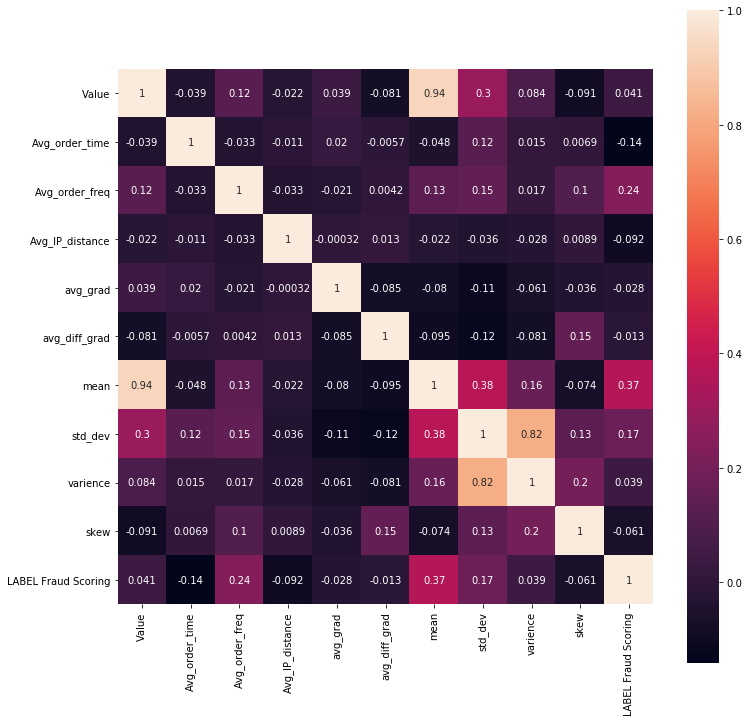

In [13]:
plt.figure(figsize = (12, 12))
seaborn.heatmap(df_num_scaled.corr(), square = True, annot = True)

Now let' take a look to a pairplot. Bad news, our numerical features don't seem to have gaussian distribution. Good news, negative observations usually look like outliers on scatter plots.

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


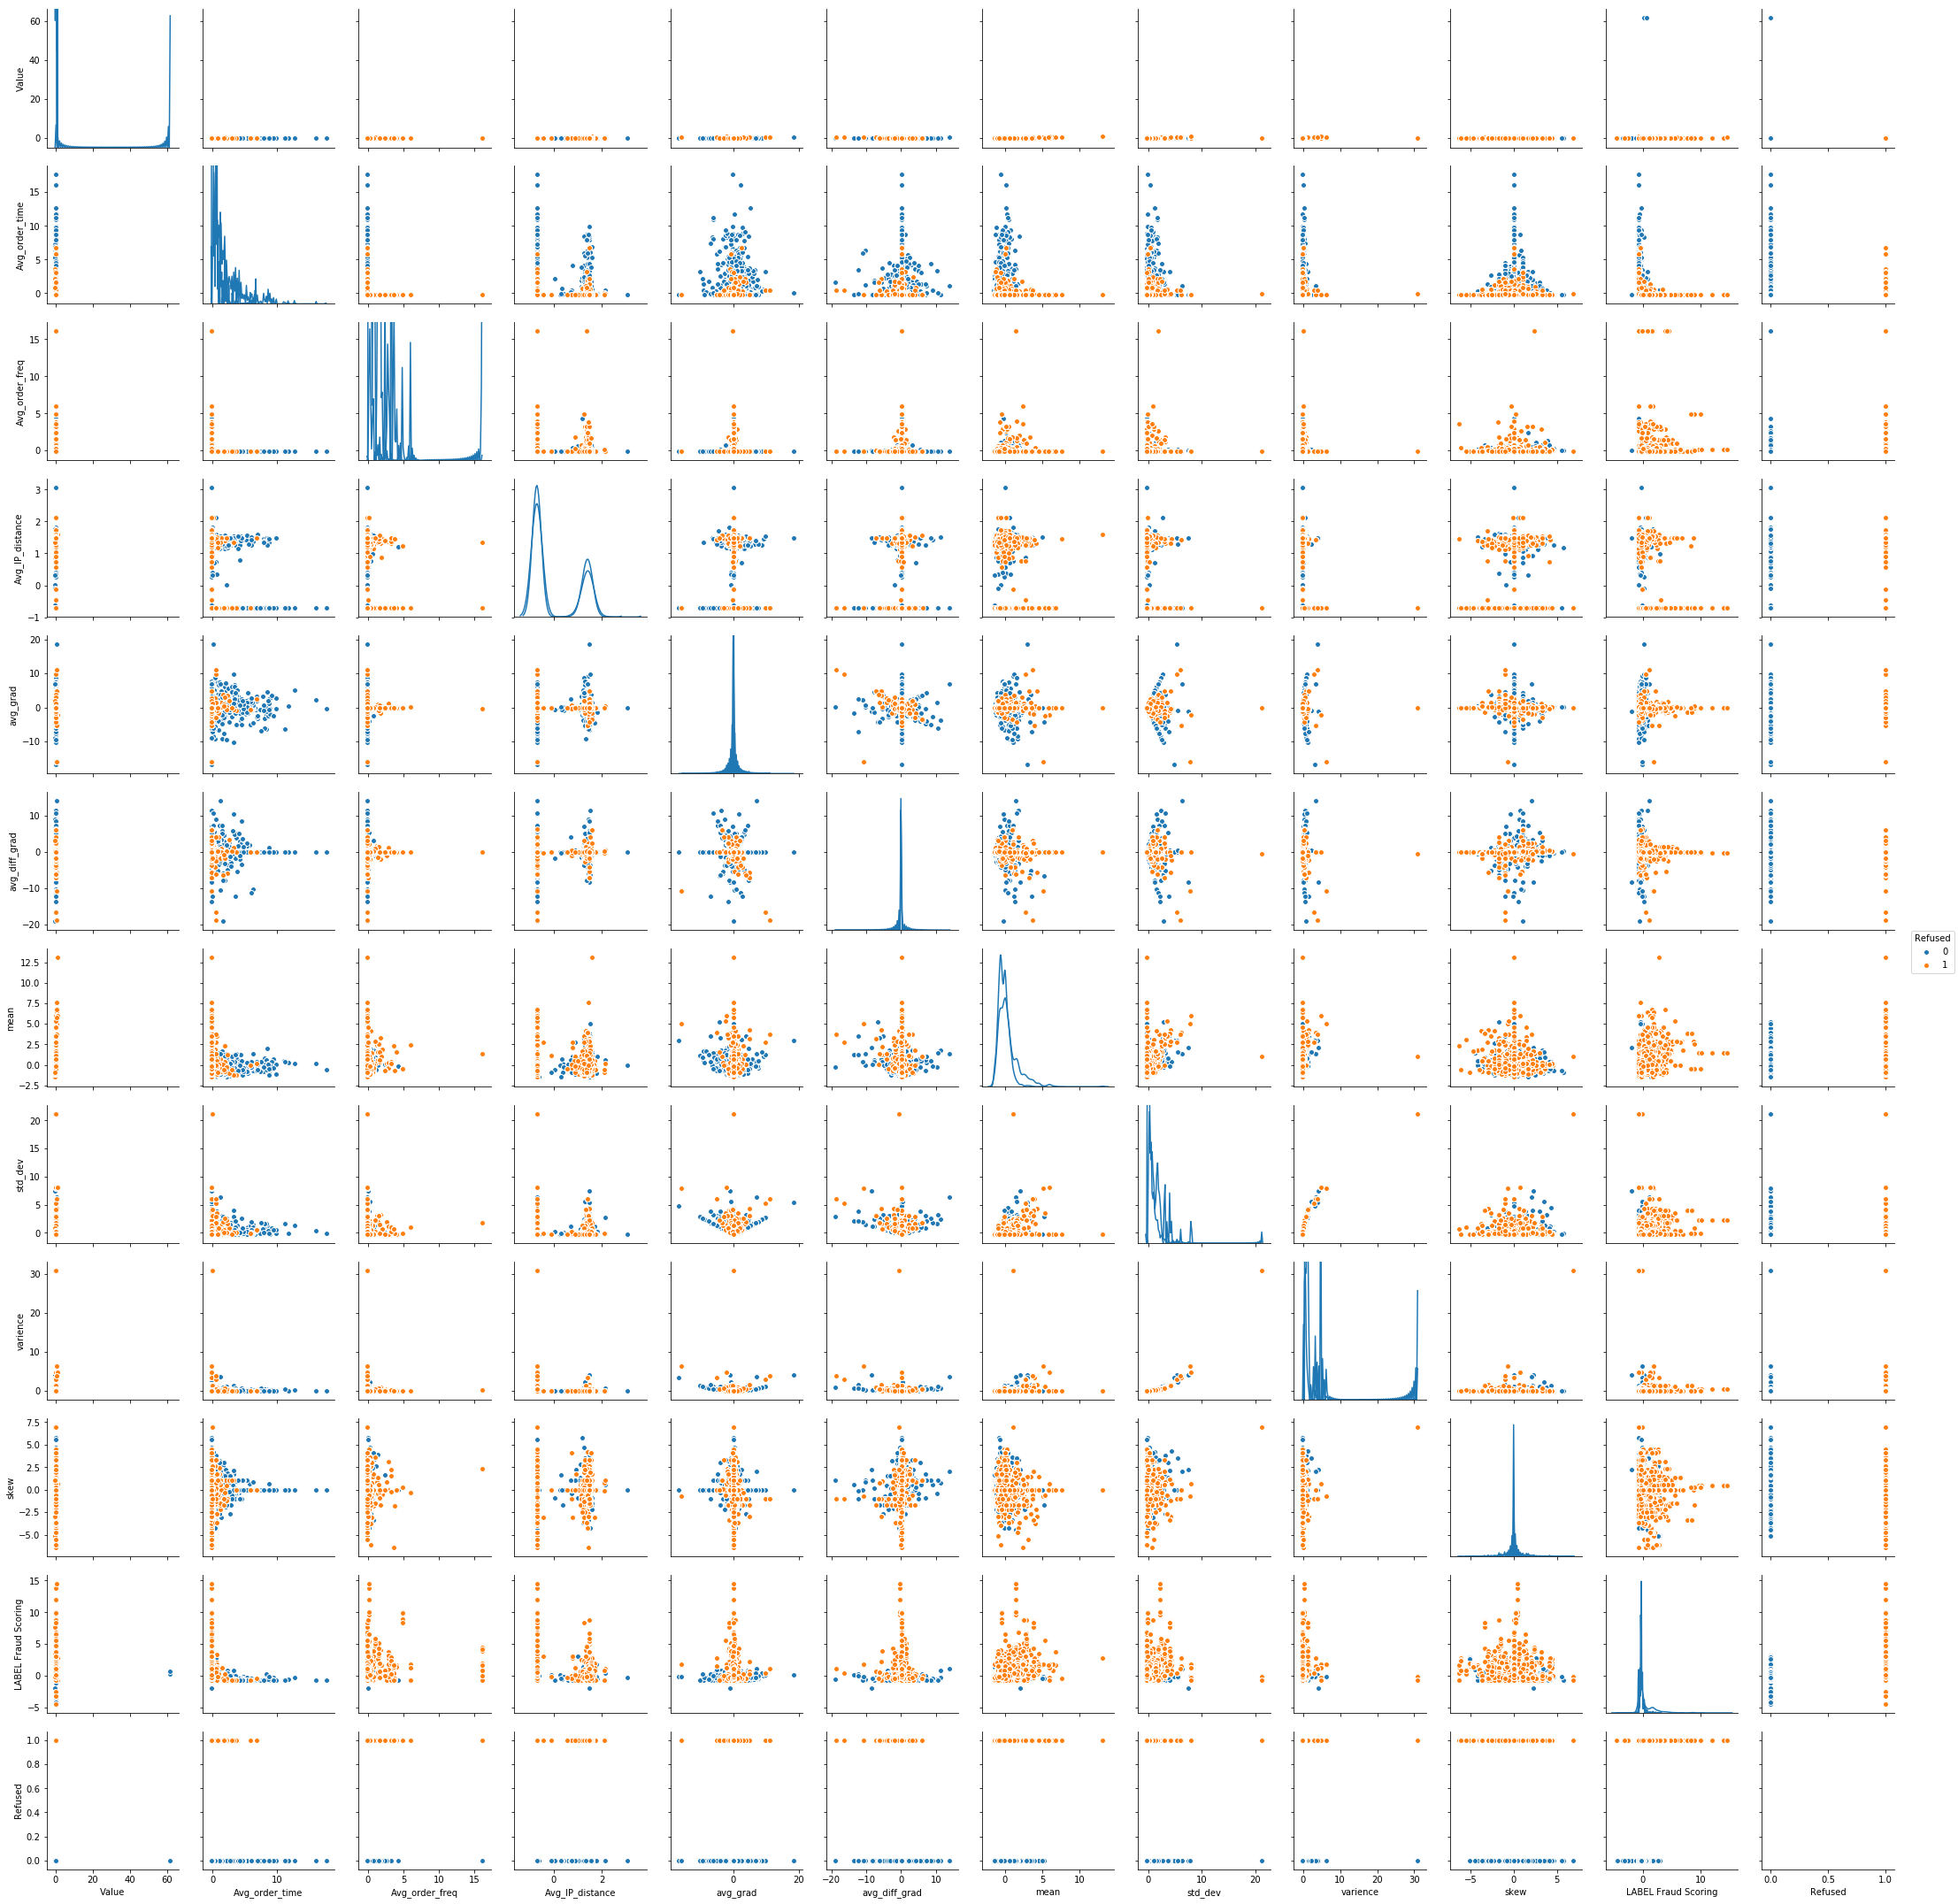

In [14]:
df_num_scaled['Refused'] = df['Refused']
seaborn.pairplot(df_num_scaled, hue = 'Refused', diag_kind = 'kde')

Finally we will use t-SNE algorithm to view if anomalies could be visually detected in reduced to 2 dimensions space. And we see, that though outliers are visually recognizable, they aren't in specific clusters.

t-SNE algorithm computationally is very expensive, do not rerun this part!

In [152]:
tsne = TSNE(n_components = 2, random_state = 147, method = 'exact')

df_num_scaled.dropna(axis = 0, inplace = True)
y_tsne = df_num_scaled['Refused'].values
df_num_scaled.drop(['LABEL Fraud Scoring', 'Refused'], axis = 1, inplace = True)
tsne_reduction = tsne.fit_transform(df_num_scaled)

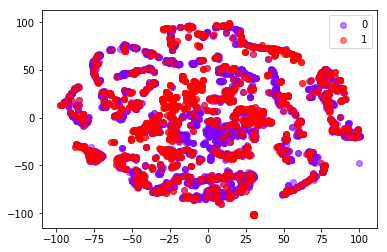

In [153]:
colors = cm.rainbow(np.linspace(0, 1, len(set(y_tsne))))
for y, c in zip(set(y_tsne), colors):
    plt.scatter(tsne_reduction[y_tsne == y, 0], tsne_reduction[y_tsne == y, 1], c = c, alpha = 0.5, label = str(y))
plt.legend()

### Feature Engineering

We will work with two features to create new: <u>'Shopper IP'</u> and <u>'Creation Date'</u>. First idea, there are many unique IP's in the dataset, let's count frequency of every IP, and build countplot. We see that for unique IP's the number of fradulent attempts is low, but as the frequency of IP increases, the number of fradulent attempts also increases. There are two strange IP adresses, more than $300$ attempts where made from them, and only small part was considered as fraudulent. These IPs are $10.246.11.6$ and $10.246.12.115$. Whois gives the following information:

<i>These addresses are in use by many millions of independently operated networks, which might be as small as a single computer connected to a home gateway, and are automatically configured in hundreds of millions of devices.  They are only intended for use within a private context  and traffic that needs to cross the Internet will need to use a different, unique address.
These addresses can be used by anyone without any need to coordinate with IANA or an Internet registry.  The traffic from these addresses does not come from ICANN or IANA.  We are not the source of activity you may see on logs or in e-mail records.</i>

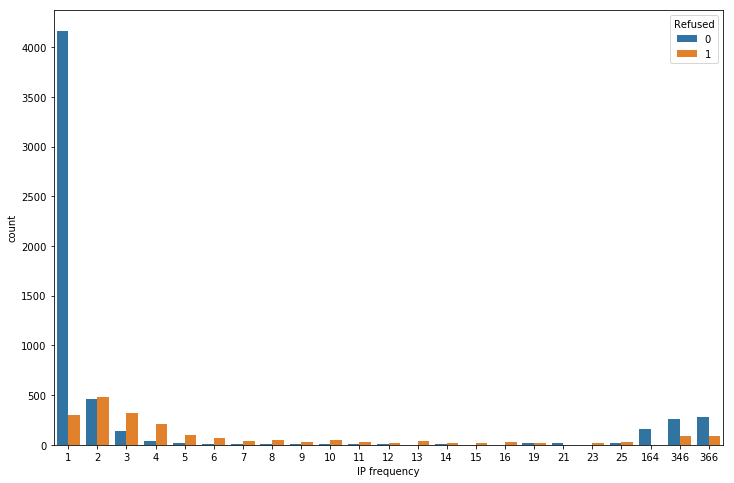

In [131]:
df_num['IP frequency'] = df_cat['Shopper IP'].map(df_cat.groupby('Shopper IP').size())
plt.figure(figsize = (12, 8))
seaborn.countplot(x = 'IP frequency', data = df_num, hue = df['Refused'])

As we have seen, high frequency of IP corresponds to higher probability of fraudulent attempt. So we'll create a binary feature <u>'Is IP freq'</u> equal to $1$, if <u>'IP frequancy'</u> is greater than $1$ (but less than $346$). And we see, that for frequent IPs there are twice more fraudulent attempts.

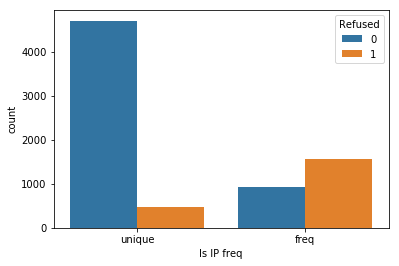

In [132]:
df_cat['Is IP freq'] = ['freq' if 1 < x < 300 else 'unique' for x in df_num['IP frequency']]
seaborn.countplot(x = 'Is IP freq', data = df_cat, hue = df['Refused'])

Another idea of feature engineering is to calculate difference between attempts of the same IP address. Underlying idea is that a good customer doesn't make purchases very often, but in case of fraudulent attempt, another attempts would be made in short periods of time. We also drop feature <u>'LABEL Fraud Scoring'</u>, as it won't be used for anomaly detection.

In [158]:
df_num.drop('LABEL Fraud Scoring', axis = 1, inplace = True)
df_num['IP time diff'] = df.sort_values('Creation Date').groupby('Shopper IP')['Creation Date'].diff().fillna(0).astype('timedelta64[s]')
df_num['IP time diff'].describe()

count      7673.000000
mean       6018.394631
std       44444.014703
min           0.000000
25%           0.000000
50%           0.000000
75%          76.000000
max      760265.000000
Name: IP time diff, dtype: float64

We delete feature <u>'Shopper IP'</u>, because we have created features based on it, and we reduce the number of categories, so if the frequency is less than $10$, we delete this category and mark it as other.

In [134]:
df_cat.drop(['Shopper IP'], axis = 1, inplace = True)
for feature in df_cat.columns:
    feature_counts = df_cat[feature].value_counts()
    df_cat[feature] = [x if feature_counts[x] >= 10 else 'Other' for x in df_cat[feature].values]
    print(feature, df_cat[feature].nunique())

3D Authenticated 5
3D Offered 4
Browser 7
Device type 5
Issuer Country 9
Liability Indicator 3
Payment Method 7
Shopper Country 11
Shopper Interaction 2
User Name 3
ver_phone 2
Is IP freq 2


## Building a model

### Data preprocessing

So this is the summary of steps of data preprocessing:

* We create dummy variables for categorical features
* We make $70 / 15 / 15$ train validation test split
* As we will train two models of anomaly detection: One Class SVM and Isolation Forest, so preprocessing of numerical features will be different
* For SVM we will replace missing values by mean, and after that we will perform feature scaling
* For isolation forest, we will replace missing values by 0, and no feature scaling. Usually we replace for tree based algorithmes missing values by a very huge number, but for outliers detection it isn't a good solution.

In [205]:
imputer = Imputer()
scaler = StandardScaler()

df_cat = pd.get_dummies(df_cat)
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(df_num.values, df_cat.values, 
                                                 df[['LABEL Fraud Scoring', 'Refused']].values, test_size = 0.3, 
                                                 random_state = 147, stratify = df['Refused'].values)

X_train_num_svm = imputer.fit_transform(X_train_num)
X_test_num_svm = imputer.transform(X_test_num)
X_train_num_svm = scaler.fit_transform(X_train_num_svm)
X_test_num_svm = scaler.transform(X_test_num_svm)

X_train_num_if = np.nan_to_num(X_train_num)
X_test_num_if = np.nan_to_num(X_test_num)

X_val_num_svm, X_test_num_svm, X_val_num_if, X_test_num_if, X_val_cat, X_test_cat, y_val, y_test = \
                               train_test_split(X_test_num_svm, X_test_num_if, X_test_cat, y_test, 
                               test_size = 0.5, random_state = 147, stratify = y_test[:,1])

X_train_svm = np.concatenate((X_train_num_svm, X_train_cat), axis = 1)
X_val_svm = np.concatenate((X_val_num_svm, X_val_cat), axis = 1)
X_test_svm = np.concatenate((X_test_num_svm, X_test_cat), axis = 1)

X_train_if = np.concatenate((X_train_num_if, X_train_cat), axis = 1)
X_val_if = np.concatenate((X_val_num_if, X_val_cat), axis = 1)
X_test_if = np.concatenate((X_test_num_if, X_test_cat), axis = 1)

print('№ train set observations: {:d}; № train set features: {:d}'.format(X_train_svm.shape[0], X_train_svm.shape[1]))
print('№ val set observations: {:d}; № val set features: {:d}'.format(X_val_svm.shape[0], X_val_svm.shape[1]))
print('№ test set observations: {:d}; № test set features: {:d}'.format(X_test_svm.shape[0], X_test_svm.shape[1]))

№ train set observations: 5371; № train set features: 72
№ val set observations: 1151; № val set features: 72
№ test set observations: 1151; № test set features: 72


### One Class SVM

We use here One Class SVM, an unsupervised machine learning algorithm for anomaly detection. As we can't use here cross_val_score or GridSearchCV, so we use here a validation set to choose the best hyperparameters according to accuracy score with validation subset of <u>'Refused'</u> feature. For the best model, accuracy score is about $0.747$, and that's not bad as we haven't solved this problem as a classification task. 

In [262]:
gammas = np.logspace(-3, 1, 9)
nus = np.linspace(0.01, 0.25, 9)
accuracy_svm = np.zeros((len(gammas), len(nus)))
for i in range(len(gammas)):
    for j in range(len(nus)):        
        svm_detector = OneClassSVM(gamma = gammas[i], nu = nus[j], random_state = 147)
        svm_detector.fit(X_train_svm)
        svm_predict = np.array([0 if x == 1 else 1 for x in svm_detector.predict(X_val_svm)])
        accuracy_svm[i, j] = accuracy_score(y_val[:,1], svm_predict)
max_svm = np.max(accuracy_svm)
best_gamma = gammas[np.argmax(accuracy_svm) // accuracy_svm.shape[0]]
best_nu = nus[np.argmax(accuracy_svm) % accuracy_svm.shape[0]]
print('Best SVM accuracy: {:f} \nBest gamma: {:f} \nBest nu: {:f}'.format(max_svm, best_gamma, best_nu))

Best SVM accuracy: 0.747176 
Best gamma: 0.010000 
Best nu: 0.130000


### Isolation Forest

Isolation Forest is another unsupervised learning algorithm for anomaly detection, but built on decision trees. Here we use the same idea, using validation set, we choose the optimal number of trees and optimal percentage of observations, supposed to be anomalies. We see that the highest accuracy here is $0.775$, so Isolation Forest outperforms One Class SVM.

In [263]:
n_trees = np.linspace(10, 50, 9)
contams = np.linspace(0.01, 0.25, 9)
accuracy_if = np.zeros((len(n_trees), len(contams)))
for i in range(len(n_trees)):
    for j in range(len(contams)):
        if_detector = IsolationForest(n_estimators = int(n_trees[i]), contamination = contams[j], random_state = 147)
        if_detector.fit(X_train_if)
        if_predict = np.array([0 if x == 1 else 1 for x in if_detector.predict(X_val_if)])
        accuracy_if[i, j] = accuracy_score(y_val[:,1], if_predict)
max_if = np.max(accuracy_if)
best_n_trees = n_trees[np.argmax(accuracy_if) // accuracy_if.shape[0]]
best_contam = contams[np.argmax(accuracy_if) % accuracy_if.shape[0]]
print('Best IF accuracy: {:f} \nBest number of trees: {:f} \nBest contamination: {:f}'.format(max_if, best_n_trees, best_contam)) 

Best IF accuracy: 0.774978 
Best number of trees: 20.000000 
Best contamination: 0.070000


### Ensembe detector 

And if we would try to use both anomaly detection models? Unfortunately, either One Class SVM or Isolation Forest return vector of $-1$ if anomaly and $1$ if not, and not probability of being anomaly, so we can't calculate mean of probabilities to decide. Therefore let's try to make strict and soft ensemble detectors:

* For strict detector, an observation is an anomaly if it is anomaly for both models
* For soft detector, an observation is an anomaly if it is anomaly for at least one model

We see, that both strict and soft detectors work better than One Class SVM, but worse than Isolation Forest. So the chosen anomaly detection algorithm is Isolation Forest on $20$ trees and $7\%$ of anomalies. 

In [264]:
best_svm = OneClassSVM(gamma = best_gamma, nu = best_nu, random_state = 147)
best_svm.fit(X_train_svm)
best_svm_val = np.array([0 if x == 1 else 1 for x in best_svm.predict(X_val_svm)])

best_if = IsolationForest(n_estimators = int(best_n_trees), contamination = best_contam, random_state = 147)
best_if.fit(X_train_if)
best_if_val = np.array([0 if x == 1 else 1 for x in best_if.predict(X_val_if)])

strict_val = np.array([1 if ((best_if_val[i] == 1) & (best_svm_val[i] == 1)) else 0 for i in range(len(best_if_val))])
soft_val = np.array([1 if ((best_if_val[i] == 1) | (best_svm_val[i] == 1)) else 0 for i in range(len(best_if_val))])

strict_val_score = accuracy_score(y_val[:,1], strict_val)
soft_val_score = accuracy_score(y_val[:,1], soft_val)

print('Strict validation accuracy score: {:f} \nSoft validation accuracy score: {:f}'.format(strict_val_score, soft_val_score))

Strict validation accuracy score: 0.757602 
Soft validation accuracy score: 0.764553


### Using with test data

Finally let's see the result of the best model on test set. The result is lower than on validation set, but the difference is not very significant.

In [266]:
best_if_test = np.array([0 if x == 1 else 1 for x in best_if.predict(X_test_if)])
if_test_score = accuracy_score(y_test[:,1], best_if_test)
print('Accuracy score of the best model on test set: {:f}'.format(if_test_score))

Accuracy score of the best model on test set: 0.760209


## Conclusion

It is quite difficult to compare this model and the original one, because they use different approaches, original model calculates score for every observation, higher is the score, higher is the probability of fraud attempt. And the output of built model is binary, either observation is common or it is outlier. 
As it was mentioned earlier, there are a lot of questions on this data set, so from my point of view it is not correct to make decisions about performance of the model on the real data. Nevertheless we could achieved accuracy score of $0.76$ on test set treating task as unsupervised machine learning problem. Maybe classification approach would improve the performance, but we should take into account that we are sure in fraud only if fraudulent attempt was successful, in attempt was refused, we would almost never know, if it was a fraudulent attempt or common customer. 
To build our model we used two algorithmes for anomaly detection: One Class SVM and Isolation Forest. There are a lot of ways to try to improve the result:

* Try to use another algorithm, for example Autoencoders or Local Outlier Factor
* Try more feature engineering and feature selection
* Try other methods to work with missing variables and categorical features

But there is no guarantee that any of them will huge improve model's performance.

# Machine learning for Back Market

There are a lot of machine learning algorithms that could be used for Back Market:

* Chatbot creation, so user could receive online help 24/7.  
* Computer vision category classification, product recognition would be very hard task, for example even a specialist hardly could distinguish iMac 2017 from iMac 2016, but for more general categories like MacBook Pro / MacBook Air, Canon / Nikon this will work.
* Stock prediction, and predictions of periods of higher demand.
* Customers and reconditioning manufactures segmentation.
* Customers fidelity study, to predict taking into account his purchases and site history, if he would buy anything in the nearest future.
* Recommandation system, that not only shows items that might be interesting according to purchase history, but also sends alert, if new item could be interesting, for example somebody has bought Canon 5DM3, and he receives a message, that objectif 70-200 is available.

Of course all of these ideas might be already realized or in development, but here are several ideas that from my point of view could be useful. 